# Import data & parse

In [1]:
from os import listdir
from os.path import join, isdir, isfile
from typing import TypedDict
import json

DATA_PREFIX = "Using data type "
INSTANCE_PREFIX = "Using instance type "
CRITERIA_PREFIX = "Using criteria "
FP_RUN_MAX_LEN_PREFIX = "Foot paths run max len "
BENCHMARK_PREFIX = "Benchmark of "

UNKNOWN_LITERAL = "Unknown"


def parse_bench_time(bench_time: str) -> int:
    """00:00:093.9852490000003"""
    total_ms = 0

    for i, part in enumerate(bench_time.split(":")):
        total_ms += round(float(part)) * (
            60 * 1_000 if i == 0 else 1_000 if i == 1 else 1
        )

    return total_ms


class Result(TypedDict):
    data: str
    instance: str
    criteria: list[str]
    fp_run_max_len: int

    # Benchmarks
    compute_data: tuple[int, int]
    create_instance: tuple[int, int]
    run: tuple[int, int]
    result: tuple[int, int]
    post_treatment: tuple[int, int]


results: dict[str, Result] = {}

RESULTS_FOLDER = "./results"

for node in listdir(RESULTS_FOLDER):
    node_path = join(RESULTS_FOLDER, node)
    if isdir(node_path):
        for file in listdir(node_path):
            file_path = join(node_path, file)
            if file == "out.txt" and isfile(file_path):
                print(f"Loading {file_path} ...", end=" ")
                try:
                    with open(file_path) as raw_output:
                        result = Result(
                            data=UNKNOWN_LITERAL,
                            instance=UNKNOWN_LITERAL,
                            criteria=[UNKNOWN_LITERAL],
                            fp_run_max_len=-1,
                            compute_data=(0, -1),
                            create_instance=(0, -1),
                            run=(0, -1),
                            result=(0, -1),
                            post_treatment=(0, -1),
                        )

                        for line in raw_output:
                            line = line[:-1]

                            if line.startswith(DATA_PREFIX):
                                result["data"] = line[len(DATA_PREFIX) :]
                            elif line.startswith(INSTANCE_PREFIX):
                                result["instance"] = line[len(INSTANCE_PREFIX) :]
                            elif line.startswith(CRITERIA_PREFIX):
                                result["criteria"] = json.loads(
                                    line[len(CRITERIA_PREFIX) :]
                                )
                            elif line.startswith(FP_RUN_MAX_LEN_PREFIX):
                                result["fp_run_max_len"] = json.loads(
                                    line[len(FP_RUN_MAX_LEN_PREFIX) :]
                                )

                            elif line.startswith(BENCHMARK_PREFIX):
                                # Benchmarks
                                line = line[len(BENCHMARK_PREFIX) :]

                                fun_name = line.split(" ")[0]
                                line = line[len(fun_name + " (") :]

                                times = int(line.split(" ")[0])
                                line = line[len(str(times) + " times): ") :]

                                duration = parse_bench_time(line)

                                if fun_name.startswith("compute"):
                                    result["compute_data"] = (times, duration)
                                elif fun_name.startswith("create"):
                                    result["create_instance"] = (times, duration)
                                elif fun_name.startswith("run"):
                                    result["run"] = (times, duration)
                                elif fun_name.startswith("result"):
                                    result["result"] = (times, duration)
                                elif fun_name.startswith("postTreatment"):
                                    result["post_treatment"] = (times, duration)

                        results[node] = result
                        print("Done.")
                except Exception as exc:
                    print(f"Error: {exc}")

Loading ./results/int-sr/out.txt ... Done.
Loading ./results/scal-r/out.txt ... Done.
Loading ./results/int-mcsr/out.txt ... Done.
Loading ./results/scal-sr/out.txt ... Done.
Loading ./results/scal-mcr/out.txt ... Done.
Loading ./results/int-r/out.txt ... Done.
Loading ./results/int-mcr/out.txt ... Done.
Loading ./results/scal-mcsr/out.txt ... Done.


# Format data

In [2]:
results_list = sorted(results.items(), key=lambda result: result[0])

# Plot

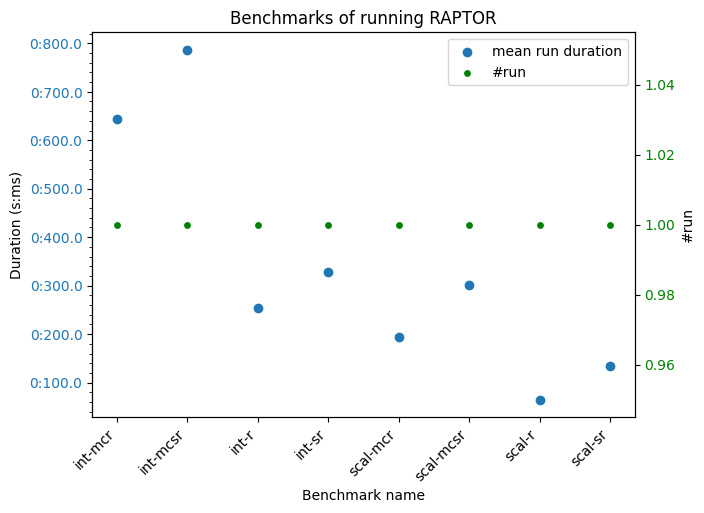

In [3]:
from math import floor
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator


def format_ms(ms: float):
    return f"{floor(ms / 1000)}:{ms % 1000}"


fig, ax = plt.subplots(figsize=(7, 5))

ax_sc = ax.scatter(
    range(len(results_list)),
    [result["run"][1] for (_, result) in results_list],
    label="mean run duration",
)
_ = ax.set_xticks(
    range(len(results_list)),
    [result_name for (result_name, _) in results_list],
    rotation=45,
    ha="right",
)
ax.tick_params(axis="y", labelcolor=ax_sc.get_facecolors())
ax.yaxis.set_major_formatter(lambda x, _: format_ms(x))
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_ylabel("Duration (s:ms)")
ax.set_xlabel("Benchmark name")

ax2 = ax.twinx()
ax2_sc = ax2.scatter(
    range(len(results_list)),
    [result["run"][0] for (_, result) in results_list],
    s=15,
    color="green",
    label="#run",
)
ax2.tick_params(axis="y", labelcolor=ax2_sc.get_facecolors())
ax2.set_ylabel("#run")

_ = fig.legend(
    loc="upper right",
    # https://stackoverflow.com/a/47370214
    bbox_to_anchor=(1, 1),
    bbox_transform=ax.transAxes,
)
_ = ax.set_title("Benchmarks of running RAPTOR")